In [1]:
import os
import requests
import xmltodict
import json
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import threading


In [2]:
# This function downloads the exchange rate for one day and one currency
def get_day(base, date_str):
    # I made a folder for the currency in case it didn't
    folder = os.path.join("data", base)
    os.makedirs(folder, exist_ok=True)

    file_path = os.path.join(folder, f"{date_str}.json")
    
    # If I already saved this file before, skip it. I had to check because I was running into issues
    if os.path.exists(file_path):
        print(f"skipping {base} on {date_str}")
        return

    # This is the floatrates.com URL with the date and base currency
    url = f"https://www.floatrates.com/historical-exchange-rates.html?operation=rates&pb_id=1775&page=historical&currency_date={date_str}&base_currency_code={base}&format_type=xml"
    
    try:
        r = requests.get(url, timeout=10)
        r.raise_for_status()  # if it failed, it'll raise an error covering my bases)
        xml_data = xmltodict.parse(r.text)  # turns XML into Python dictionary

        # Saves the result as a JSON file
        with open(file_path, "w") as f:
            json.dump(xml_data, f, indent=2)

        print(f"saved {base} on {date_str}")
    except Exception as e:
        print(f"failed to get {base} on {date_str}: {e}")

# This function loops over a date range and uses threads to download faster
def download_currency(base, start_date, end_date, max_threads=10):
    threads = []
    curr = start_date

    while curr <= end_date:
        date_str = curr.strftime("%Y-%m-%d")
        t = threading.Thread(target=get_day, args=(base, date_str))
        t.start()
        threads.append(t)

        # I kept the thread count low so it didn't overload
        if len(threads) >= max_threads:
            for thread in threads:
                thread.join()
            threads = []

        curr += timedelta(days=1)

    for thread in threads:
        thread.join()


In [3]:
# Here I actually ran the downloader for AUD (Australian Dollar) I didn't even know Australia had their own currency
# Just trying a few days to start, I can increase the range later
base = "AUD"
start = datetime(2011, 5, 4)
end = datetime(2011, 5, 6)

# This downloads the data and saves it in data/AUD/
download_currency(base, start, end)


saved AUD on 2011-05-04
saved AUD on 2011-05-06
saved AUD on 2011-05-05


In [4]:
# Tried opening the file and printing what’s inside (I was double checking just to make sure)
import json

with open("data/AUD/2011-05-04.json") as f:
    contents = json.load(f)

# Shows the raw structure
print(contents)


{'channel': {'title': 'XML Historical Foreign Exchange Rates for Australian Dollar (AUD) (4 May 2011)', 'link': 'http://www.floatrates.com/currency/aud/', 'xmlLink': 'http://www.floatrates.com/daily/aud.xml', 'description': 'XML historical foreign exchange rates for Australian Dollar (AUD) from the Float Rates. Published at 4 May 2011.', 'language': 'en', 'baseCurrency': 'AUD', 'pubDate': 'Wed, 4 May 2011', 'lastBuildDate': 'Wed, 4 May 2011', 'item': [{'title': '1 AUD = 0.727935 EUR', 'link': 'http://www.floatrates.com/aud/eur/', 'description': '1 Australian Dollar = 0.727935 Euro', 'pubDate': None, 'baseCurrency': 'AUD', 'baseName': 'Australian Dollar', 'targetCurrency': 'EUR', 'targetName': 'Euro', 'exchangeRate': '0.727935', 'inverseRate': '1.373749', 'inverseDescription': '1 Euro = 1.373749 Australian Dollar'}, {'title': '1 AUD = 0.655741 GBP', 'link': 'http://www.floatrates.com/aud/gbp/', 'description': '1 Australian Dollar = 0.655741 U.K. Pound Sterling', 'pubDate': None, 'baseCu

In [5]:

data_dir = f"./data/{base}"
files = sorted(os.listdir(data_dir))
all_data = []

for filename in files:
    path = os.path.join(data_dir, filename)
    with open(path) as f:
        raw = json.load(f)

    # The date is just the filename without .json
    date = filename.replace(".json", "")

    try:
        # I checked if the data uses the 'channel' and 'item' structure
        if 'channel' in raw and 'item' in raw['channel']:
            items = raw['channel']['item']

            # If there's just one item, wrap it in a list
            if isinstance(items, dict):
                items = [items]

            # goes through each currency exchange rate
            for r in items:
                all_data.append({
                    'date': date,
                    'currency': r['targetCurrency'],
                    'rate': float(r['exchangeRate'].replace(',', '')),  # handle commas
                })
        else:
            print(f"{filename} doesn't contain usable exchange rate data.")

    except Exception as e:
        print(f"Error in {filename}: {e}")


In [6]:
# Now I'm turning my list of exchange rates into a DataFrame so I can analyze it
df = pd.DataFrame(all_data)

# this makees sure the date column is in proper date time format for sorting and plotting
df['date'] = pd.to_datetime(df['date'])

# this just checks to see if it loads correctly
df.head()


,date,currency,rate
0,2011-05-04,EUR,0.727935
1,2011-05-04,GBP,0.655741
2,2011-05-04,USD,1.083313
3,2011-05-04,DZD,77.232653
4,2011-05-04,AUD,1.000000


In [7]:
# This  pretty much shows how much each currency's rate varies (standard deviation)
stability = df.groupby('currency')['rate'].std().sort_values()

# Least volatile currencies (very stable)
print("Most stable currencies:")
print(stability.head())

# Most volatile currencies (rates jump around more)
print("\nMost volatile currencies:")
print(stability.tail())


Most stable currencies:
currency
AUD    0.000000
KWD    0.002147
NZD    0.002323
CAD    0.002744
OMR    0.002798
Name: rate, dtype: float64

Most volatile currencies:
currency
KRW     1.630300
HUF     2.161142
CLP     2.652915
COP    12.899590
IDR    49.777559
Name: rate, dtype: float64


In [8]:
# Turning my list of exchange rate records into a pandas DataFrame
df = pd.DataFrame(all_data)

# Making sure the 'date' column is in datetime format so I can sort and plot by time
df['date'] = pd.to_datetime(df['date'])

# Previews the first few rows to make sure it actually worked
df.head()


,date,currency,rate
0,2011-05-04,EUR,0.727935
1,2011-05-04,GBP,0.655741
2,2011-05-04,USD,1.083313
3,2011-05-04,DZD,77.232653
4,2011-05-04,AUD,1.000000


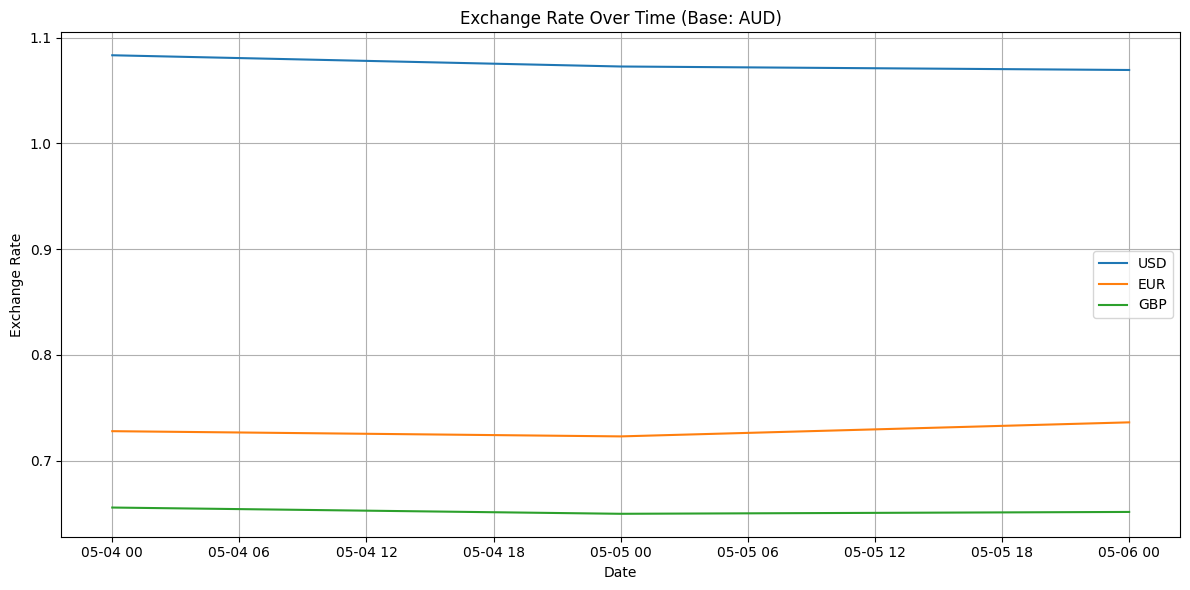

In [ ]:
# I'm comparing a few currencies against AUD over time
plot_currencies = ["USD", "EUR", "GBP"]

plt.figure(figsize=(12, 6))

# Plots a line for each currency
for cur in plot_currencies:
    subset = df[df['currency'] == cur]
    plt.plot(subset['date'], subset['rate'], label=cur)

# I made graphs and labels with styling
plt.title(f"Exchange Rate Over Time (Base: {base})")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
